# Scaling with Combinators and the Static Modeling Language

Up until this point, we have been using [Gen's generic built-in modeling language](https://probcomp.github.io/Gen/dev/ref/modeling/#Built-in-Modeling-Language-1), which is a very flexible modeling language that is shallowly embedded in Julia. However, better performance and scaling characteristics can be obtained using specialized modeling languages or modeling constructs. This notebook introduces two built-in features of Gen:

- A more specialized [Static Modeling Language](https://probcomp.github.io/Gen/dev/ref/modeling/#Static-Modeling-Language-1) which is built-in to Gen.

- A class of modeling constructs called [Generative function combinators](https://probcomp.github.io/Gen/dev/ref/combinators/).

These features provide both constant-factor speedups, as well as improvements in asymptotic orders of growth, over the generic built-in modeling language.


## Outline

**Section 1**: [Studying the scaling behavior of an inference algorithm](#scaling)

**Section 2**: [Introducing the map combinator](#map)

**Section 3**: [Combining the map combinator with the static modeling language](#combining)

**Section 4**: [Constant-factor performance gains from the static modeling language](#constant)

**Section 5**: [Checking the inference programs](#checking)

In [1]:
using Gen
import Random
import Pkg
Pkg.update()
Pkg.add("DSP")
using DSP
Pkg.add("CSV")
using CSV
Pkg.add("PyPlot")
using PyPlot

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `/probcomp/Gen/Project.toml`
 [no changes]
  Updating `/probcomp/Gen/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `/probcomp/Gen/Project.toml`
 [no changes]
  Updating `/probcomp/Gen/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `/probcomp/Gen/Project.toml`
 [no changes]
  Updating `/probcomp/Gen/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `/probcomp/Gen/Project.toml`
 [no changes]
  Updating `/probcomp/Gen/Manifest.toml`
 [no changes]


In [2]:
artery_dataframe = CSV.read("/probcomp/Gen/case-studies/makima_ksactivities.csv", datarow=1)
artery_interpolated = dropdims(Matrix(artery_dataframe), dims=1)

3602-element Array{Float64,1}:
 0.0061326
 0.010385 
 0.013891 
 0.015818 
 0.015619 
 0.014193 
 0.012877 
 0.013007 
 0.015683 
 0.020012 
 0.024343 
 0.028761 
 0.034191 
 ⋮        
 0.84114  
 0.84096  
 0.84079  
 0.84062  
 0.84044  
 0.84027  
 0.8401   
 0.83993  
 0.83977  
 0.8396   
 0.83944  
 0.83928  

In [3]:
recon_times = [10., 23., 37., 53., 70., 89., 109., 131., 154., 179., 205., 233., 262., 293., 325., 359., 394., 431., 469., 509., 550., 593., 637., 683., 730., 779., 829., 881., 934., 990., 1047., 1106., 1166., 1228., 1291., 1356., 1422., 1490., 1559., 1630., 1702., 1776., 1852., 1930., 2009., 2090., 2172., 2256., 2341., 2428., 2516., 2607., 2699., 2793., 2888., 2985., 3083., 3183., 3284., 3388., 3493., 3601.]

62-element Array{Float64,1}:
   10.0
   23.0
   37.0
   53.0
   70.0
   89.0
  109.0
  131.0
  154.0
  179.0
  205.0
  233.0
  262.0
    ⋮  
 2516.0
 2607.0
 2699.0
 2793.0
 2888.0
 2985.0
 3083.0
 3183.0
 3284.0
 3388.0
 3493.0
 3601.0

In [4]:
N_not_outlier = 7

7

## 1. Studying the scaling behavior of an inference program <a name="studying"></a>

In [5]:
# HUANG 1980

function huang1980_solution(k1::Float64, k2::Float64, k3::Float64, k4::Float64, t0::Float64, v1::Float64)    
    # @param artery must have 1 Hz sampling
    
    scale = 1. # from calibration data
    n = length(artery_interpolated)
    ts = collect(0.:1.:n-1.)
    k234 = k2 + k3 + k4
    alpha = 0.5 * (k234 - sqrt(k234 * k234 - 4. * k2 * k4))
    beta  = 0.5 * (k234 + sqrt(k234 * k234 - 4. * k2 * k4))    
    conva_art = conv(exp.(-alpha .* ts), artery_interpolated) # gradients fail on conv()
    convb_art = conv(exp.(-beta .* ts),  artery_interpolated)
    conva = view(conva_art, 1:n)
    convb = view(convb_art, 1:n)
    conv2 = (k4 - alpha) .* conva .- (beta - k4) .* convb
    conv3 =                 conva .-                convb
    q2 = (k1 / (beta - alpha)) .* conv2
    q3 = (k3 * k1 / (beta - alpha)) .* conv3
    q_ = v1 .* (artery_interpolated .+ scale .* (q2 .+ q3))
    t0 > 0 ? view(vcat(zeros(floor(Int, t0)), q_), 1:n) : q_
end;

@gen function huang1980_model(ts::Vector{Float64})
    # First, generate some parameters of the model. We make these
    # random choices, because later, we will want to infer them
    # from data. The distributions we use here express our assumptions
    # about the parameters: we think that the noise is relatively small; and that
    # the proportion of the dataset that doesn't fit the model relationship
    # (outliers) could be anything between 0 and 1.
    # @param ts has non-uniform sampling of smaller length than that of artery_interpolated.
    # @param qs has non-uniform sampling of ts
    
    k1 = @trace(gamma(0.24, 0.5), :sk1) # E{} ~ 0.12
    k2 = @trace(gamma(0.16, 1.), :sk2) # E{} ~ 0.16
    k3 = @trace(gamma(0.05, 1.), :sk3) # E{} ~ 0.05
    k4 = @trace(uniform(1.e-5, 1.e-3), :k4) # E{} ~ 1.e-4
    t0 = @trace(uniform(0., 30.), :t0)
    v1 = 0.04 # @trace(gamma(4, 0.01), :v1) # E{} ~ 0.04
    noise = @trace(gamma(1, 0.1), :noise) # fraction of qs
    prob_outlier = @trace(uniform(0, 0.05), :prob_outlier)
    
    # Next, we generate the actual model output.
    solution = huang1980_solution(k1, k2, k3, k4, t0, v1)
    n = length(ts)
    qs = Vector{Float64}(undef, n)    
    for i = 1:n
        
        # Decide whether this point is an outlier, and set
        # mean and standard deviation accordingly
        if i > N_not_outlier && @trace(bernoulli(prob_outlier), :qdata => i => :is_outlier)
            (mu, std) = (solution[i], solution[i])
        else
            (mu, std) = (solution[i], noise * solution[i])
        end
        # Sample an output value for this point
        qs[i] = maximum((0., @trace(normal(mu, std), :qdata => i => :q)))
    end
    return qs
end;

function h1980_block_resimulation_update(tr)
    
    # Block 1: Update the model's parameters
    model_params = select(:noise, :k1, :k2, :k3, :k4, :t0)
    (tr, _) = mh(tr, model_params)
    
    # Blocks 2:N+1: Update the outlier classifications for index > N_not_outlier
    (ts,) = get_args(tr)
    n = length(ts)
    for i = (N_not_outlier + 1):(n - N_not_outlier)
        (tr, _) = mh(tr, select(:qdata => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    return tr
end;

function h1980_make_constraints(qs::Vector{Float64})
    constraints = choicemap()
    for i = 1:length(qs)
        constraints[:qdata => i => :q] = qs[i]
    end
    constraints
end;

function h1980_block_resimulation_inference(model, ts::Vector{Float64}, qs::Vector{Float64})
    observations = h1980_make_constraints(qs)
    (tr, _) = generate(model, (ts,), observations)
    for iter=1:1000
        tr = h1980_block_resimulation_update(tr)
    end
    tr
end;

[10.0, 23.0, 37.0, 53.0, 70.0, 89.0, 109.0, 131.0]


┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = traceat(::Gen.GFGenerateState, ::Gen.Gamma, ::Tuple{Float64,Float64}, ::Symbol) at gamma.jl:12
└ @ Gen /probcomp/Gen/src/modeling_library/gamma.jl:12
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = traceat(::Gen.GFGenerateState, ::Gen.Gamma, ::Tuple{Int64,Float64}, ::Symbol) at gamma.jl:12
└ @ Gen /probcomp/Gen/src/modeling_library/gamma.jl:12
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = traceat(::Gen.GFRegenerateState, ::Gen.Gamma, ::Tuple{Float64,Float64}, ::Symbol) at gamma.jl:12
└ @ Gen /probcomp/Gen/src/modeling_library/gamma.jl:12
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = traceat(::Gen.GFRegenerateState, ::Gen.Gamma, ::Tuple{Int64,Float64}, ::Symbol) at gamma.jl:12
└ @ Gen /probcomp/Gen/src/modeling_library/gamma.jl:12


[10.0, 23.0, 37.0, 53.0, 70.0, 89.0, 109.0, 131.0, 154.0, 179.0, 205.0, 233.0, 262.0, 293.0, 325.0, 359.0]
[10.0, 23.0, 37.0, 53.0, 70.0, 89.0, 109.0, 131.0, 154.0, 179.0, 205.0, 233.0, 262.0, 293.0, 325.0, 359.0, 394.0, 431.0, 469.0, 509.0, 550.0, 593.0, 637.0, 683.0, 730.0, 779.0, 829.0, 881.0, 934.0, 990.0, 1047.0]


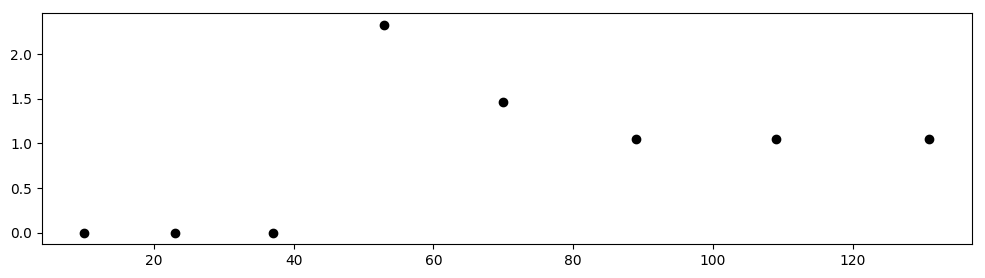

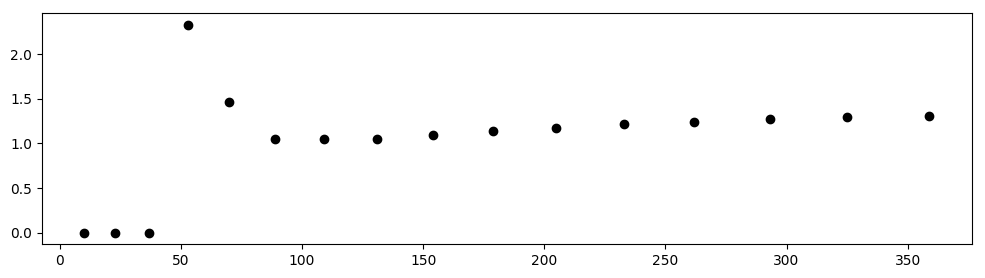

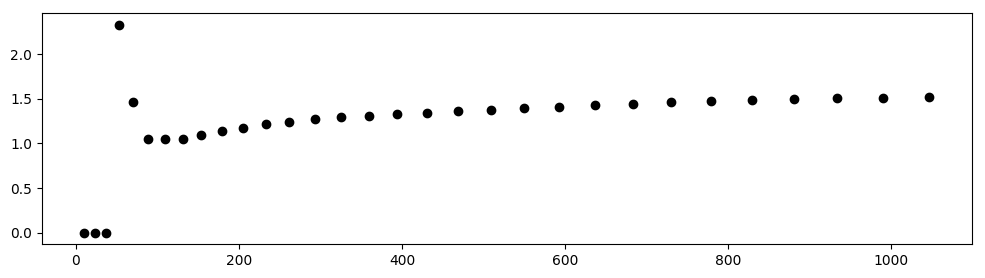

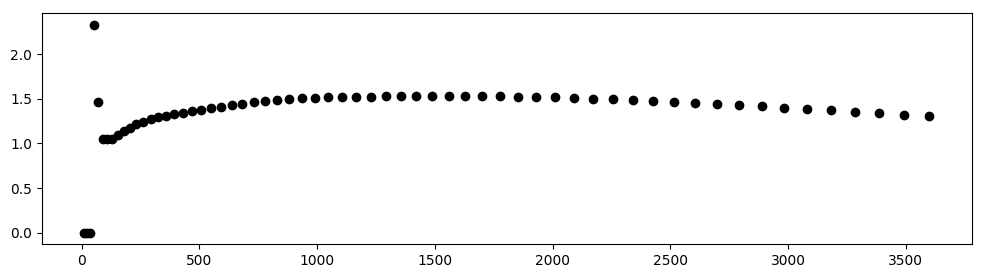

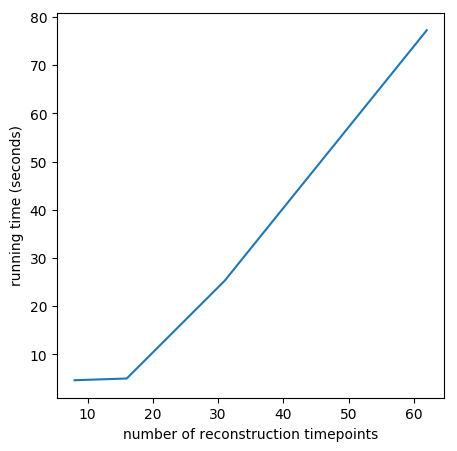

[10.0, 23.0, 37.0, 53.0, 70.0, 89.0, 109.0, 131.0, 154.0, 179.0, 205.0, 233.0, 262.0, 293.0, 325.0, 359.0, 394.0, 431.0, 469.0, 509.0, 550.0, 593.0, 637.0, 683.0, 730.0, 779.0, 829.0, 881.0, 934.0, 990.0, 1047.0, 1106.0, 1166.0, 1228.0, 1291.0, 1356.0, 1422.0, 1490.0, 1559.0, 1630.0, 1702.0, 1776.0, 1852.0, 1930.0, 2009.0, 2090.0, 2172.0, 2256.0, 2341.0, 2428.0, 2516.0, 2607.0, 2699.0, 2793.0, 2888.0, 2985.0, 3083.0, 3183.0, 3284.0, 3388.0, 3493.0, 3601.0]


In [6]:
h1980_ns = [8, 16, 31, 62]
h1980_runtimes = []
synthetic = huang1980_solution(0.1*rand(), 0.1*rand(), 0.1*rand(), 5.e-4*rand(),
                               30., 0.04)
for (i, _) in enumerate(synthetic)
    if synthetic[i] < 0.
        synthetic[i] = 0.
    end
end
    
for n in h1980_ns
    ts = Float64[];
    qs = Float64[];
    for i = 1:n
        push!(ts, recon_times[i])
        push!(qs, synthetic[ceil(Int, recon_times[i])]);
    end
    figure(figsize=(12,3))
    scatter(ts, qs, color="black");
    println(ts)
    
    start = time_ns()
    tr = h1980_block_resimulation_inference(huang1980_model, ts, qs)
    push!(h1980_runtimes, (time_ns() - start) / 1e9)
end
figure(figsize=(5,5))
plot(h1980_ns, h1980_runtimes)
xlabel("number of reconstruction timepoints")
ylabel("running time (seconds)");

## 2. Introducing the map combinator <a name="map"></a>

To use the map combinator to express the conditional independences in our model, we first write a generative function to generate the `is_outlier` variable and the y-coordinate for a single data point:

We then apply the Map, which is a Julia function, to this generative function, to obtain a new generative function:

This new generative function has one argument for each argument of `generate_single_point`, except that these arguments are now vector-valued instead of scalar-valued. We can run the generative function on some fake data to test this:

We see that the `generate_all_points` function has traced 5 calls to `generate_single_point`, under namespaces `1` through `5`.  The `Map` combinator automatically adds these indices to the trace address.

Now, let's replace the Julia `for` loop in our model with a call to this new function:

Note that this new model has the same address structure as our original model had, so our inference code will not need to change. For example, the 5th data point's $y$ coordinate will be stored at the address `:data => 5 => :y`, just as before. (The `:data` comes from our `@trace` invocation in the `better_model` definition, and the `:y` comes from `generate_point`; only the `5` has been inserted automatically by `Map`.)

We see that the quadratic scaling did not improve. In fact, we actually got a that happed was a constant factor **slowdown**.

We can understand why we still have quadratic scaling, by examining the call to `generate_single_point`:

```julia
ys = @trace(generate_all_points(xs, fill(prob_outlier, n), fill(noise, n), fill(slope, n), fill(intercept, n)), :data)
```

Even though the function `generate_all_points` knows that each of the calls to `generate_single_point` is conditionally independent, and even it knows that each update to `is_outlier` only involves a single application of `generate_single_point`, it does not know that **none of its arguments change** within an update to `is_outlier`. Therefore, it needs to visit each call to `generate_single_point`. The generic built-in modeling language does not provide this information the generative functions that it invokes.

## 3.Combining the map combinator with the static modeling language <a name="combining"></a>

In order to provide `generate_all_points` with the knowledge that its arguments do not change during an update to the `is_outlier` variable, we need to write the top-level model generative function that calls `generate_all_points` in the [Static Modeling Language](https://probcomp.github.io/Gen/dev/ref/modeling/#Static-Modeling-Language-1), which is a restricted variant of the built-in modeling language that uses static analysis of the computation graph to generate specialized trace data structures and specialized implementations of trace operations. We indicate that a function is to be interpreted using the static language using the `static` annotation:

The static language has a number of restrictions that make it more amenable to static analysis than the unrestricted modeling language. For example, we cannot use Julia `for` loops, and the return value needs to explicitly use the `return` keyword, followed by a symbol (e.g. `ys`). Also, each symbol used on the left-hand side of an assignment must be unique. A more complete list of restrictions is given in the documentation.

Below, we show the static dependency graph that Gen builds for this function. Arguments are shown as diamonds, Julia computations are shown as squares, random choices are shown as circles, and calls to other generative function are shown as stars. The call that produces the return value of the function is shaded in blue.

<img src="graph.png" width="100%"/>

Now, consider the update to the `is_outlier` variable:
```julia
(tr, _) = mh(tr, select(:data => i => :is_outlier))
```

Because this update only causes values under address `:data` to change, the `static_model_with_map` function can use the graph above to infer that none of the arguments to `generate_all_point` could have possibly changed. This will allow us to obtain the linear scaling we expected.

However, before we can use a function written in the static modeling language, we need to run the following function (this is required for technical reasons, because functions written in the static modeling language use a staged programming feature of Julia called *generated functions*).

In [7]:
Gen.load_generated_functions()

Finally, we can re-run the experiment with our model that combines the map combinator with the static language:

We compare the results to the results for the earlier models:

We see that we now have the linear running time that we expected.

## 4. Constant-factor performance gains from the static modeling language <a name="constant"></a>

Note that in our latest model above, `generate_single_point` was still written in the generic modeling language. It is not necessary to write `generate_single_point` in the static language, but doing so can provide modest constant-factor performance improvements. Here we rewrite this function in the static language. Note that we had to make some changes to fit into the more restrictive syntax of the static language:

In [221]:
# HUANG 1980

using FunctionalCollections: PersistentVector
using Gen: ifelse

function view_conv_arterial(rate::Float64, ts::Vector{Float64})
    n = length(ts)
    f = exp.(-rate .* ts)    
    g = conv(f, artery_interpolated)
    h = view(g, 1:n)
    return h
end;

@gen (static) function generate_datum(t::Float64, 
                       (grad)(k1::Float64), (grad)(k2::Float64), (grad)(k3::Float64), 
                       (grad)(noise::Float64), (grad)(prob_outlier::Float64))
    # k3 := k1 * k3 from Huang to reduce co-linearity of k1 and k3
    
    scale = 1. # from calibration data
    v1 = 0.04 # K1 := k1 v1
    k4 = 1.e-4
    t0 = 0.

    n = length(artery_interpolated)
    ts = collect(0.:1.:n-1.)
    k234 = k2 + k3 + k4
    alpha = 0.5 * (k234 - sqrt(k234 * k234 - 4. * k2 * k4))
    beta  = 0.5 * (k234 + sqrt(k234 * k234 - 4. * k2 * k4))
    conva = view_conv_arterial(alpha, ts)
    convb = view_conv_arterial(beta, ts)
    conv2 = (k4 - alpha) .* conva .- (beta - k4) .* convb
    conv3 =                 conva .-                convb
    q2 = (k1 / (beta - alpha)) .* conv2
    q3 = (k1 * k3 / (beta - alpha)) .* conv3
    q_ = v1 .* (artery_interpolated .+ scale .* (q2 .+ q3))
    #q__ = ifelse(t0 > 0, vcat(zeros(floor(Int, t0)), q_), q_)
    signal = q_[ceil(Int, t)]
    
    is_outlier = @trace(bernoulli(prob_outlier), :sis_outlier)
    frac_std = ifelse(is_outlier, 1.0, noise)
    qq_ = @trace(normal(signal, signal * frac_std), :sq)
    qq__ = maximum((0., qq_))
    return qq__
end;

generate_data = Map(generate_datum);

@gen (static) function huang1980_static_model(ts::Vector{Float64})
    k1 = @trace(gamma(0.3, 0.4), :sk1) # E{} ~ 0.12
    k2 = @trace(gamma(0.4, 0.4), :sk2) # E{} ~ 0.16
    k3 = @trace(gamma(0.5, 0.1), :sk3) # E{} ~ 0.05
    #k4 = @trace(gamma(100., 1.e-6), :sk4) # E{} ~ 1.e-4
    #t0 = @trace(gamma(100., 0.03), :st0)
    #t0 = @trace(uniform(0., 20.), :st0) # degrades inference badly
    noise = @trace(gamma(1., 0.1), :snoise)
    prob_outlier = @trace(uniform(0, 1), :sprob_outlier)
    n = length(ts)
    @trace(generate_data(
           ts, fill(k1, n), fill(k2, n), fill(k3, n), 
           fill(noise, n), vcat(zeros(N_not_outlier), fill(prob_outlier, n-N_not_outlier))),
           :sdata)
end;

In [9]:
Pkg.add("PyCall")
using PyCall
@pyimport graphviz
using Gen: draw_graph
draw_graph(huang1980_static_model, graphviz, "test")

 Resolving package versions...
  Updating `/probcomp/Gen/Project.toml`
 [no changes]
  Updating `/probcomp/Gen/Manifest.toml`
 [no changes]


┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:407
└ @ PyCall /root/.julia/packages/PyCall/ttONZ/src/PyCall.jl:407
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = draw_graph(::StaticIR, ::Module, ::String) at render_ir.jl:33
└ @ Gen /probcomp/Gen/src/static_ir/render_ir.jl:33
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = draw_graph(::StaticIR, ::Module, ::String) at render_ir.jl:35
└ @ Gen /probcomp/Gen/src/static_ir/render_ir.jl:35
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = draw_graph(::

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /root/.julia/packages/PyCall/ttONZ/src/pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'graphviz.backend.ExecutableNotFound'>
ExecutableNotFound("failed to execute ['dot', '-Tpdf', '-O', 'test'], make sure the Graphviz executables are on your systems' PATH",)
  File "/venv/lib/python3.5/site-packages/graphviz/files.py", line 209, in render
    quiet=quiet)
  File "/venv/lib/python3.5/site-packages/graphviz/backend.py", line 206, in render
    run(cmd, capture_output=True, cwd=cwd, check=True, quiet=quiet)
  File "/venv/lib/python3.5/site-packages/graphviz/backend.py", line 162, in run
    raise ExecutableNotFound(cmd)


In [222]:
function h1980_static_update(tr)
    
    # Block 1: Update the model's parameters
    model_params = StaticSelection(select(:snoise, :sk1, :sk2, :sk3))
    (tr, _) = mh(tr, model_params)
    
    # Blocks 2:N+1: Update the outlier classifications for index > N_not_outlier
    (ts,) = get_args(tr)
    n = length(ts)
    for i = (2 * N_not_outlier + 1):n
        (tr, _) = mh(tr, select(:sdata => i => :sis_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:sprob_outlier))
    
    # Return the updated trace
    return tr
end;

function h1980_static_constraints(qs::Vector{Float64})
    constraints = choicemap()
    for (i, q) in enumerate(qs)
        constraints[:sdata => i => :sq] = q
    end
    return constraints
end;

function h1980_static_inference(model, ts::Vector{Float64}, qs::Vector{Float64})
    observations = h1980_static_constraints(qs)
    (tr, _) = generate(model, (ts,), observations)
    for iter = 1:50
        tr = h1980_static_update(tr)
    end
    return tr
end;

Gen.load_generated_functions()

[10.0, 23.0, 37.0, 53.0, 70.0, 89.0, 109.0, 131.0]


┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = generate(::getfield(Main, Symbol("##StaticGenFunction_huang1980_static_model#465")), ::Tuple{Array{Float64,1}}, ::StaticChoiceMap{(),Tuple{},(:sdata,),Tuple{DynamicChoiceMap}}) at gamma.jl:12
└ @ Main /probcomp/Gen/src/modeling_library/gamma.jl:12
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = logpdf at gamma.jl:12 [inlined]
└ @ Core /probcomp/Gen/src/modeling_library/gamma.jl:12
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = logpdf at gamma.jl:12 [inlined]
└ @ Core /probcomp/Gen/src/modeling_library/gamma.jl:12
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = generate(::getfield(Main, Symbol("##StaticGenFunction_huang1980_static_model#465")), ::Tuple{Array{Float64,1}}, ::StaticChoiceMap{(),Tuple{},(:sdata,),Tuple{DynamicChoiceMap}}) at gamma.jl:12
└ @ Main /probco

[10.0, 23.0, 37.0, 53.0, 70.0, 89.0, 109.0, 131.0, 154.0, 179.0, 205.0, 233.0, 262.0, 293.0, 325.0, 359.0]
[10.0, 23.0, 37.0, 53.0, 70.0, 89.0, 109.0, 131.0, 154.0, 179.0, 205.0, 233.0, 262.0, 293.0, 325.0, 359.0, 394.0, 431.0, 469.0, 509.0, 550.0, 593.0, 637.0, 683.0, 730.0, 779.0, 829.0, 881.0, 934.0, 990.0, 1047.0]


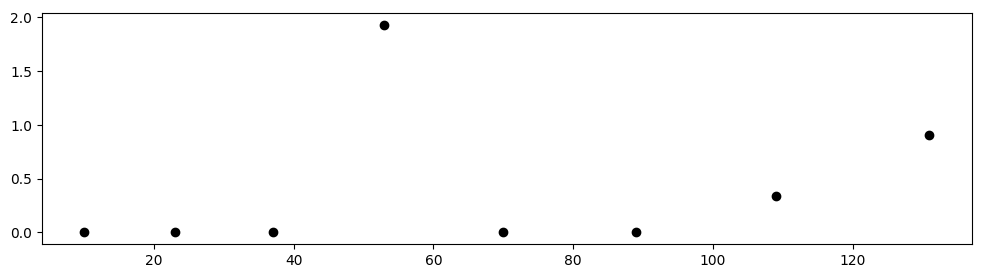

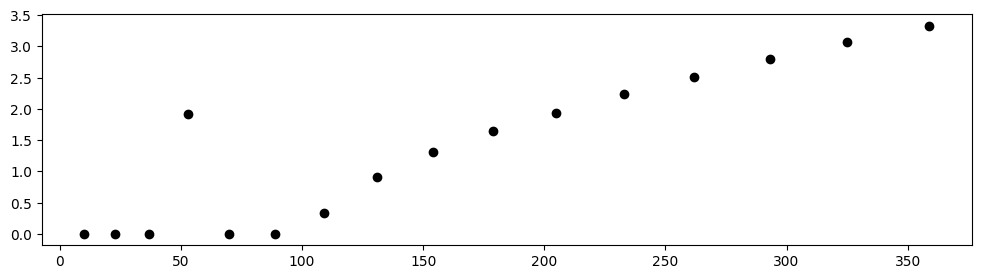

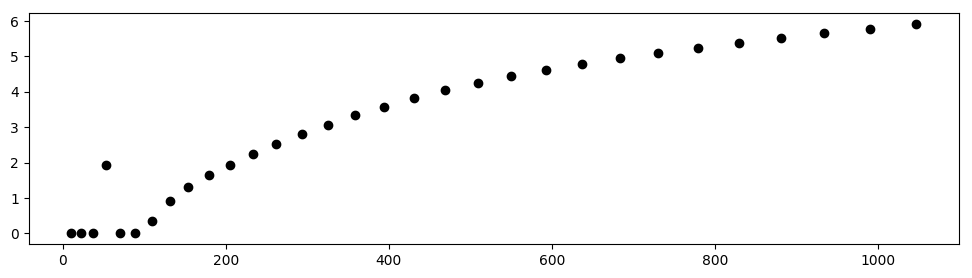

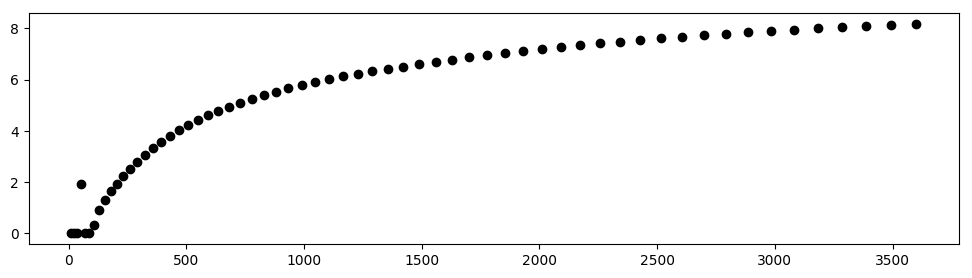

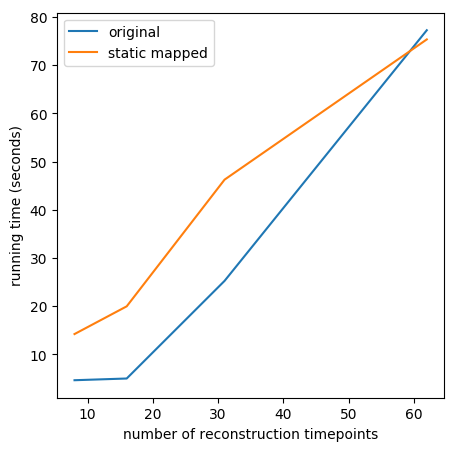

[10.0, 23.0, 37.0, 53.0, 70.0, 89.0, 109.0, 131.0, 154.0, 179.0, 205.0, 233.0, 262.0, 293.0, 325.0, 359.0, 394.0, 431.0, 469.0, 509.0, 550.0, 593.0, 637.0, 683.0, 730.0, 779.0, 829.0, 881.0, 934.0, 990.0, 1047.0, 1106.0, 1166.0, 1228.0, 1291.0, 1356.0, 1422.0, 1490.0, 1559.0, 1630.0, 1702.0, 1776.0, 1852.0, 1930.0, 2009.0, 2090.0, 2172.0, 2256.0, 2341.0, 2428.0, 2516.0, 2607.0, 2699.0, 2793.0, 2888.0, 2985.0, 3083.0, 3183.0, 3284.0, 3388.0, 3493.0, 3601.0]


In [11]:
h1980_static_runtimes = []
synthetic = huang1980_solution(0.1*rand(), 0.1*rand(), 0.1*rand(), 5.e-4*rand(),
                               30., 0.04)
for (i, _) in enumerate(synthetic)
    if synthetic[i] < 0.
        synthetic[i] = 0.
    end
end

for n in h1980_ns
    ts_ = Float64[];
    qs_ = Float64[];
    for i = 1:n
        push!(ts_, recon_times[i])
        push!(qs_, synthetic[ceil(Int, recon_times[i])]);
    end
    figure(figsize=(12,3))
    scatter(ts_, qs_, color="black");
    println(ts_)
    
    start = time_ns()
    tr = h1980_static_inference(huang1980_static_model, ts_, qs_)
    push!(h1980_static_runtimes, (time_ns() - start) / 1e9)
end

figure(figsize=(5,5))
plot(h1980_ns, h1980_runtimes, label="original")
plot(h1980_ns, h1980_static_runtimes, label="static mapped")
xlabel("number of reconstruction timepoints")
ylabel("running time (seconds)");
legend();

## 5. Checking the inference programs <a name="checking"></a>

Before wrapping up, let's confirm that all of our models are giving good results:

Let's use a synthetic data set:

We write a trace rendering function that shows the inferred line on top of the observed data set:

Finally, we run the experiment. We will visualize just one trace produced by applying our inference program to each of the four variants of our model:

It looks like inference in all the models seems to be working reasonably.

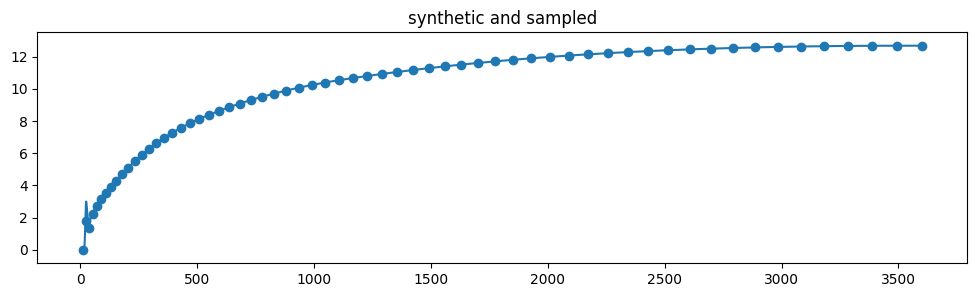

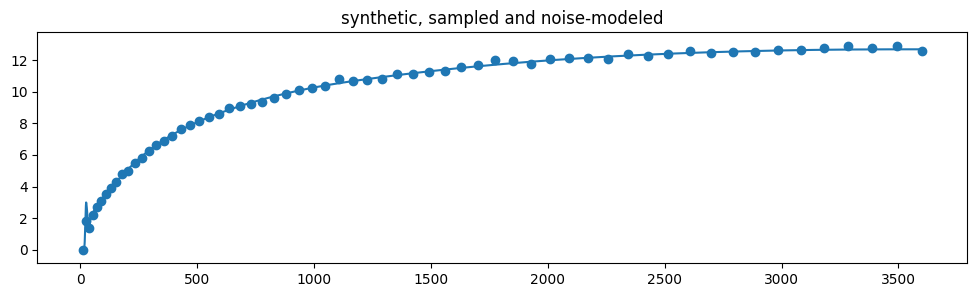

In [223]:
#synthetic = huang1980_solution(0.006, 0.01, 0.005, 5.e-4, 30., 0.04)
#synthetic = huang1980_solution(0.05, 0.05, 0.05, 1.e-4, 30., 0.04)
synthetic = huang1980_solution(0.12, 0.16, 0.05, 1.e-4, 0., 0.04)
for (i, _) in enumerate(synthetic)
    if synthetic[i] < 0.
        synthetic[i] = 0.
    end
end

true_inlier_noise = 0.01
true_outlier_noise = 1.0
true_prob_outlier = 0.001

ts = Float64[]
qs = Float64[]
rs = Float64[]
for (i_, t_) in enumerate(recon_times)
    signal_ = synthetic[ceil(Int, t_)]
    push!(ts, t_)
    push!(qs, signal_);
    if rand() < true_prob_outlier
        q_ = signal_ * (1. + randn() * true_outlier_noise)
    else
        q_ = signal_ * (1. + randn() * true_inlier_noise)
    end
    push!(rs, maximum((q_, 0.)))
end
#rs[end-1] = 0.
#rs[end] = 0.

figure(figsize=(12,3))
plot(collect(0.:1.:3601.), synthetic)
scatter(ts, qs);
title("synthetic and sampled")

figure(figsize=(12,3))
plot(collect(0.:1.:3601.), synthetic)
scatter(ts, rs)
title("synthetic, sampled and noise-modeled");

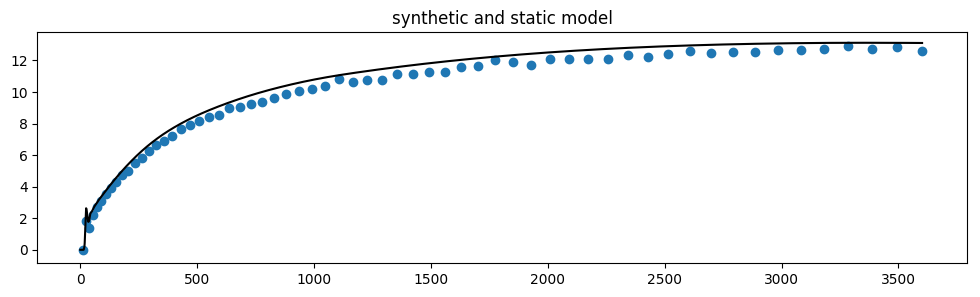

In [244]:
function render_trace(trace)
    (ts_,) = get_args(trace)
    choices_ = get_choices(trace)
    k1 = choices_[:k1]
    k2 = choices_[:k2]
    k3 = choices_[:k3]
    k4 = choices_[:k4]
    t0 = choices_[:t0]
    solution_ = huang1980_solution(k1, k2, k3, k4, t0, 0.04)
    qs_ = [choices_[:qdata => i => :q] for i = 1:length(ts_)]
    plot(0.:1.:3601., solution_, color="black")
    scatter(ts_, qs_)
end;

function render_static_trace(trace)
    (ts_,) = get_args(trace)
    choices_ = get_choices(trace)
    k1 = choices_[:sk1]
    k2 = choices_[:sk2]
    k3 = choices_[:sk3]
    solution_ = huang1980_solution(k1, k2, k3, 1.e-4, 0.0, 0.04)
    qs_ = [choices_[:sdata => i => :sq] for i = 1:length(ts_)]
    plot(0.:1.:3601., solution_, color="black")
    scatter(ts_, qs_)
end;

#figure(figsize=(12, 3))
#tr = h1980_block_resimulation_inference(huang1980_model, ts, rs)
#render_trace(tr)
#title("synthetic and model")

figure(figsize=(12, 3))
tr = h1980_static_inference(huang1980_static_model, ts, rs)
render_static_trace(tr)
title("synthetic and static model");


In [245]:
println(get_choices(tr))

│
├── :sk1 : 0.19064212872240266
│
├── :sk2 : 0.30526699359112575
│
├── :sk3 : 0.05745392227164314
│
├── :snoise : 0.01797661548205823
│
├── :sprob_outlier : 0.4245540488309114
│
└── :sdata
    │
    ├── 1
    │   │
    │   ├── :sis_outlier : false
    │   │
    │   └── :sq : 0.0005495890111674006
    │
    ├── 2
    │   │
    │   ├── :sis_outlier : false
    │   │
    │   └── :sq : 1.7993670774186945
    │
    ├── 3
    │   │
    │   ├── :sis_outlier : false
    │   │
    │   └── :sq : 1.3764604543911723
    │
    ├── 4
    │   │
    │   ├── :sis_outlier : false
    │   │
    │   └── :sq : 2.214507441855743
    │
    ├── 5
    │   │
    │   ├── :sis_outlier : false
    │   │
    │   └── :sq : 2.7285928827103203
    │
    ├── 6
    │   │
    │   ├── :sis_outlier : false
    │   │
    │   └── :sq : 3.120798301674705
    │
    ├── 7
    │   │
    │   ├── :sis_outlier : false
    │   │
    │   └── :sq : 3.5284411323461673
    │
    ├── 8
    │   │
    │   ├── :sis_outlier : true
    │   │

In [172]:
using Statistics
acc_k1 = []
acc_k2 = []
acc_k3 = []
acc_k4 = []
acc_t0 = []
for i=1:50
    tr_ = h1980_static_inference(huang1980_static_model, ts, rs)
    choices_ = get_choices(tr_)
    push!(acc_k1, choices_[:sk1])
    push!(acc_k2, choices_[:sk2])
    push!(acc_k3, choices_[:sk3])
    push!(acc_k4, choices_[:sk4])
    push!(acc_t0, choices_[:st0])
end
println("std_k1:  $(std(acc_k1)), std_k2:  $(std(acc_k2)), std_k3:  $(std(acc_k3)), std_k4:  $(std(acc_k4)), std_t0:  $(std(acc_t0))")

std_k1:  0.1520634011163854, std_k2:  0.25485865454539214, std_k3:  0.05761756262325669, std_k4:  0.00010404970881036302, std_t0:  3.733963312876736
